## Initialisation

### Dependencies

#### Third party

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

#### Personal notebook

In [2]:
import ipynb

from ipynb.fs.full.dataset_initialisation import (
    ifile,
    ofile,
    OUTPUT_DIR,
)
from ipynb.fs.defs.utilities import (
    differentiate,
)

if (os.path.exists(f'{OUTPUT_DIR}/true_strain_vs_true_stress.csv')):
    df = pd.read_csv(f'{OUTPUT_DIR}/true_strain_vs_true_stress.csv', sep=',', names=['x','y'])
    true_strain = df['x'].to_numpy()
    true_stress = df['y'].to_numpy()
else:
    from ipynb.fs.full.true_strain_stress import (
        true_stress,
        true_strain,
    )

if (os.path.exists(f'{OUTPUT_DIR}/true_plastic_strain_vs_true_stress.csv')):
    df = pd.read_csv(f'{OUTPUT_DIR}/true_plastic_strain_vs_true_stress.csv', sep=',', names=['x','y'])
    true_plastic_strain = df['x'].to_numpy()
else:
    from ipynb.fs.full.true_strain_stress import (
        true_plastic_strain,

    )

yield_strength = ifile.get_parameter('yield_strength')
if yield_strength is None:
    from ipynb.fs.full.engineering_strain_stress import (
        yield_strength,
    )

An index file already exists for tensile_test_data.csv. Do you want to re-initalise? (Y/n): n
An output file already exists for tensile_test_data.csv. Do you want to re-initalise? (Y/n): 


### Notations

- $\sigma \rightarrow$ True Stress
- $\epsilon \rightarrow$ True Strain
- $\epsilon_{pl} \rightarrow$ True Plastic Strain
- $\sigma_{ys} \rightarrow$ Yield Strength
- $\sigma_{uts} \rightarrow$ Ultimate Tensile Strength
- $n \rightarrow$ Work hardening Exponent
- $E \rightarrow$ Young's Modulus
- $K \rightarrow$ Strength Coefficient
- $e \rightarrow$ Engineering Strain
- $s \rightarrow$ Engineering Stress
- $\theta \: or \: \frac{d\sigma}{d\epsilon} \rightarrow$ Work hardening rate
- $\sigma - \sigma_{ys} \rightarrow$ Flow Stress

## Fitting hollomon equation to true stress-true strain data

### Computing work hardening exponent

There are two ways to compute it:
1. Fitting hollomon equation to experimental data
2. Taking $ log $ on both sides of the hollomon equation

### Hollomon Equation

$ \sigma = K \cdot \epsilon^n $

#### Method 1

Do you want to provide initial guess for K and n? (Y/n): 
Strength coefficient (K): 627.1528914220768
Work hardening exponent (n): 0.21515073322628733


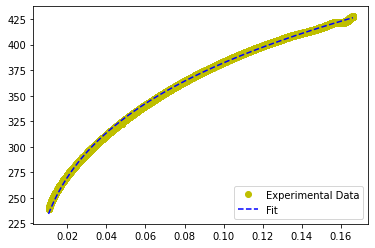

In [3]:
choose = input('Do you want to provide initial guess for K and n? (Y/n): ')

p0=None

if choose in ['Y', 'y']:
    initial_guess_n = float(input("Intial guess of work hardening exponent (0 < n < 1): "))
    initial_guess_K = float(input("Intial guess of strength coefficient (MPa): "))
    p0 = (initial_guess_K, initial_guess_n)
    
def fit_hollomon(x, K, n):
    return K*(x**n)

rhs_theoretical_hollomon = curve_fit(
    fit_hollomon, true_strain, true_stress, p0, method='lm',
)
popt, _ = rhs_theoretical_hollomon
K = popt[0]
n = popt[1]

fig, ax = plt.subplots(1,1)
_ = ax.plot(true_strain, true_stress, 'yo')
_ = ax.plot(true_strain, [fit_hollomon(pl,K,n) for pl in true_strain], 'b--')
if choose in ['Y', 'y']:
    _ = plt.plot(true_strain, [fit_hollomon(pl,initial_guess_K,initial_guess_n) for pl in true_strain], 'g:',)
    _ = plt.legend(['Experimental Data','Guess', 'Fit'], loc='lower right')

_ = ax.legend(['Experimental Data','Fit'], loc='lower right')

_ = plt.savefig(f'{OUTPUT_DIR}/Hollomon curve', facecolor='white', transparent=True)

print(f'Strength coefficient (K): {K}')
print(f'Work hardening exponent (n): {n}')

if ifile.add_parameter('K_M1', K):
    ofile.save_parameter('Strength coefficient (K) (M1)', K, 'MPa')

if ifile.add_parameter('n_M1', n):
    ofile.save_parameter('Work hardening exponent (n) (M1)', n, '')

#### Method 2

$ \sigma = K \cdot \epsilon^n \Rightarrow $ 
$ log(\sigma) = logK + nlog\epsilon $

In [4]:
log_true_stress = np.log(true_stress)
log_true_strain = np.log(true_strain)

model = LinearRegression().fit(log_true_strain.reshape(-1,1), log_true_stress)
coef = model.score(log_true_strain.reshape(-1,1), log_true_stress)
work_hard_exp = model.coef_[0]
strenght_coefficient = np.exp(model.intercept_)
print(f'Work hardening exponent: {work_hard_exp}')
print(f'Strength coefficient: {strenght_coefficient}')
print(f'Accuracy in calculations: {coef}')

if ifile.add_parameter('K_M2', K):
    ofile.save_parameter('Strength coefficient (K) (M2)', K, 'MPa')

if ifile.add_parameter('n_M2', work_hard_exp):
    ofile.save_parameter('Work hardening exponent (n) (M2)', n, '')

Work hardening exponent: 0.21351400636432838
Strength coefficient: 624.5873634153767
Accuracy in calculations: 0.9986898750963641


## Plot of $\frac{d\sigma}{d\epsilon}$ v/s $\epsilon$

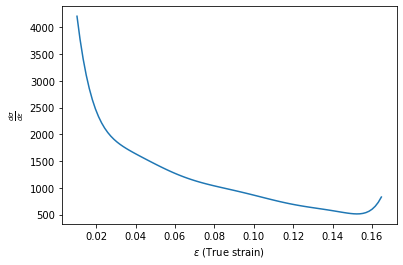

In [5]:
true_stress_smooth_coeff = np.polyfit(true_strain, true_stress, 9)

# Sir asked us to consider these number of points
consider = 101

reduced_true_strain = np.linspace(min(true_strain),max(true_strain),consider)
reduced_true_stress = np.polyval(true_stress_smooth_coeff, reduced_true_strain)

d_sigma_epsilon = differentiate(reduced_true_strain, reduced_true_stress)

fig, ax = plt.subplots(1,1)
_ = ax.plot(reduced_true_strain[:consider-1], d_sigma_epsilon)
_ = ax.set_xlabel('$\epsilon$ (True strain)')
_ = ax.set_ylabel('$\\frac{d\sigma}{d\epsilon}$')

plt.savefig(f'{OUTPUT_DIR}/Work hardening rate vs true strain', facecolor='white', transparent=False)

pd.DataFrame(
    np.transpose(np.asarray([reduced_true_strain[:consider-1], d_sigma_epsilon], dtype=object))
).to_csv(f'{OUTPUT_DIR}/true_strain_vs_work_hardening_rate.csv', index=False, header=False)

Roger Lumley, *Fundamentals of Aluminium Metallurgy: Production, Processing and Applications*, 2011, Page No 311

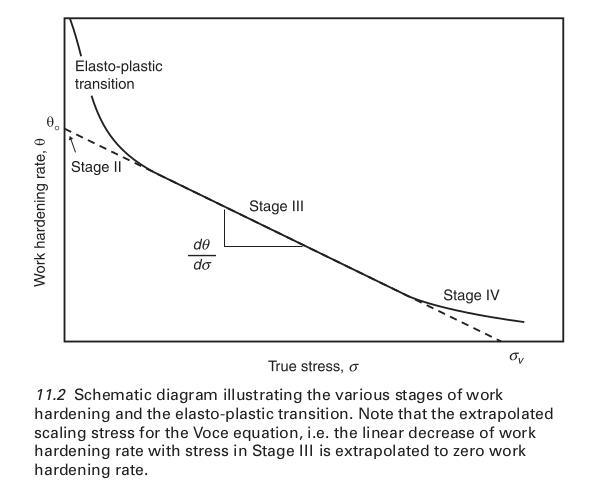

## Plot of $\frac{d\sigma}{d\epsilon}$ v/s $\frac{\sigma}{\epsilon}$

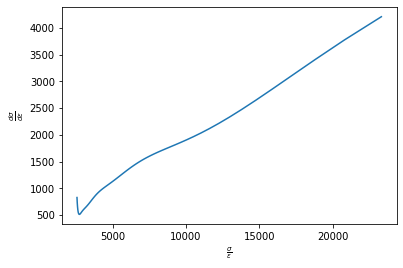

In [6]:
sigma_epsilon = np.true_divide(reduced_true_stress, reduced_true_strain)

fig, ax = plt.subplots(1,1)
_ = ax.plot(sigma_epsilon[:consider-1], d_sigma_epsilon)
_ = ax.set_xlabel('$\\frac{\sigma}{\epsilon}$')
_ = ax.set_ylabel('$\\frac{d\sigma}{d\epsilon}$')

## Plot of $\frac{d\sigma}{d\epsilon}$ v/s $\sigma - \sigma_{ys}$

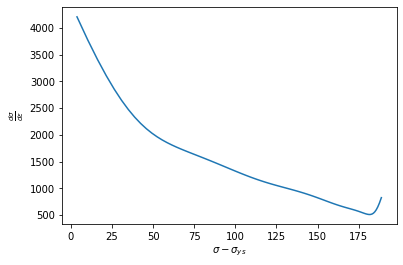

In [7]:
reduced_flow_stress = np.subtract(reduced_true_stress, float(yield_strength))

fig, ax = plt.subplots(1,1)
_ = ax.plot(reduced_flow_stress[:consider-1], d_sigma_epsilon)
_ = ax.set_xlabel('$\sigma - \sigma_{ys}$')
_ = ax.set_ylabel('$\\frac{d\sigma}{d\epsilon}$')

## Plot of $\sigma - \sigma_{ys}$ v/s $\epsilon$

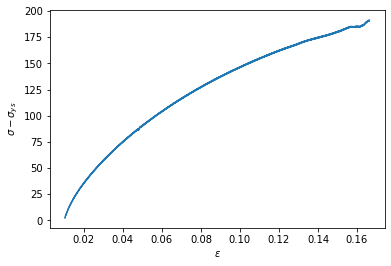

In [8]:
fig, ax = plt.subplots(1,1)
_ = ax.plot(true_strain, np.subtract(true_stress,float(yield_strength)))
_ = ax.set_ylabel('$\sigma - \sigma_{ys}$')
_ = ax.set_xlabel('$\epsilon$')